Fitting radial profiles

In [141]:
import numpy as np
from pymc import *
import astropy.table as table
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from triangle import corner
%matplotlib inline
from IPython.display import Image
from scipy.interpolate import Rbf
from matplotlib.mlab import griddata

# Create some convenience routines for plotting

def compute_sigma_level(trace1, trace2, nbins=20):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)


def plot_MCMC_trace(ax, xdata, ydata, trace, scatter=False, **kwargs):
    """Plot traces and contours"""
    xbins, ybins, sigma = compute_sigma_level(trace[0], trace[1])
    ax.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955], **kwargs)
    if scatter:
        ax.plot(trace[0], trace[1], ',k', alpha=0.1)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')
    
    
def plot_MCMC_model(ax, xdata, ydata, trace):
    """Plot the linear model and 2sigma contours"""
    ax.plot(xdata, ydata, 'ok')

    alpha, beta = trace[:2]
    xfit = np.linspace(-20, 120, 10)
    yfit = alpha[:, None] + beta[:, None] * xfit
    mu = yfit.mean(0)
    sig = 2 * yfit.std(0)

    ax.plot(xfit, mu, '-k')
    ax.fill_between(xfit, mu - sig, mu + sig, color='lightgray')

    ax.set_xlabel('x')
    ax.set_ylabel('y')


def plot_MCMC_results(xdata, ydata, trace, colors='k'):
    """Plot both the trace and the model together"""
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    plot_MCMC_trace(ax[0], xdata, ydata, trace, True, colors=colors)
    plot_MCMC_model(ax[1], xdata, ydata, trace)

[0.07905190127413575 -0.012972059205565633 -0.07398994069188053
 0.044064246109519686 -0.0162350868834638 -0.011680192487547926
 -0.024951030710449983 -0.009945106572544146 -0.209395414429827
 -0.06824710050739478 -0.006998477240809806 -0.10701647986521587
 -0.06018570633456143 -0.05781289216411587 -0.01714614258658835
 0.06546300795570272 -0.050385626595614845 -0.22905664607440415
 -0.09908633594621082 -0.2818472959922105 -0.02541853556350639
 -0.005444190317048178 0.009101128334825763 -0.04093926159915847
 0.08040831839858038 -0.3461048397189634 -0.24498320746824864
 -0.013698202943738408 -0.04969993579355839 -0.024091198875885848
 0.1123746064843758 0.08266983586097824 0.03768745725153255
 -0.8709560367989109 -0.3386128914749821 0.08146762580289507
 -0.5025536021741323 -0.03104881490329962 -0.03956347675313253
 0.033049227326296775 -0.0308064169087958 -0.13181346605292268
 -0.013979770560303579 -0.03158735566846177 0.08085908658437911
 -0.20908234024426608 -0.01577918735936796 -0.70

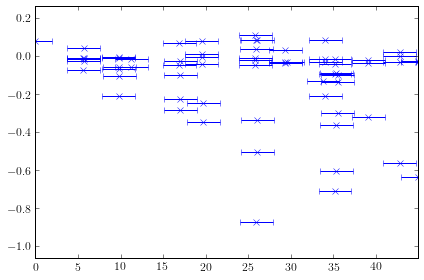

In [132]:
#pick object and quantity of interest
obj = 'NGC2558'
qty = 'Z'
fiberfits = table.Table.read('{}/fiberfits.dat'.format(obj), format = 'ascii')
#filter out sky fibers
fiberfits = fiberfits[fiberfits['sky'] != 1]
#this next line is not necessary if you mask your array and impute correctly, but I haven't figured that out yet
fiberfits = fiberfits[np.isnan(fiberfits['V']) == False]
r = fiberfits['r']
dr_fiber = 1.932 * np.ones(len(r))
dx_fiber, dy_fiber = dr_fiber / np.sqrt(2), dr_fiber / np.sqrt(2)

ydata = np.ma.masked_array(np.asarray(fiberfits[qty]), np.isnan(fiberfits[qty]))
print ydata

if 'd' + qty in fiberfits.columns:
    yerr = fiberfits['d' + qty]
else: yerr = None
    
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(r, ydata, visible = False)
ylims = ax.get_ylim()
yr = ylims[1] - ylims[0]
ylims = (ylims[0] - 0.05*yr, ylims[1] + 0.05*yr)

ax.errorbar(r, ydata, xerr = dr_fiber, yerr = yerr, fmt = 'x', c = 'b')
ax.set_xlim([0., np.max(r)])
ax.set_ylim(ylims)
plt.tight_layout()
plt.show()

# Try fitting a simple radial metallicity profile

In [133]:
'''
model:

straight line (no measurement errors)

y_{i} = a + tan(beta) * x_{i}

specifying slope as an angle is better

sigma_y can be thought of as "intrinsic scatter"
'''

#priors
alpha = Uniform('alpha', lower = -2., upper = 1.)
beta = Uniform('beta', lower = -np.pi/2., upper = np.pi/2.)
sig = Uniform('sig', lower = 0., upper = 1.)

#actual model
@deterministic
def mod_lin(x = r, alpha = alpha, beta = beta):
    return alpha + np.tan(beta) * x

#likelihood
y = Normal('y', mu = mod_lin, tau = 1./sig**2., value = ydata, observed = True)

pymc_simple_linear = dict(alpha = alpha, beta = beta, sig = sig, y = y)

 [-----------------100%-----------------] 10000 of 10000 complete in 5.7 sec

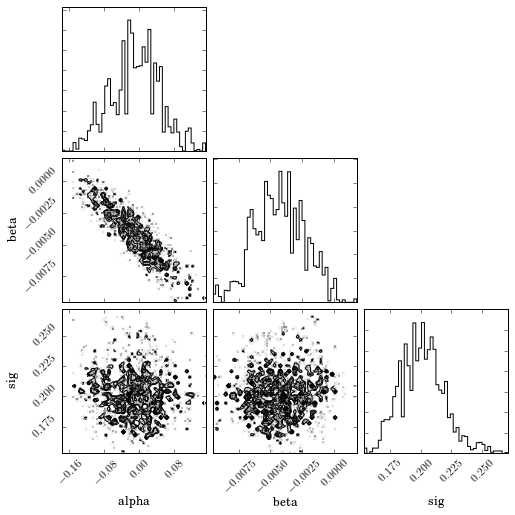

Plotting beta
Plotting alpha
Plotting sig


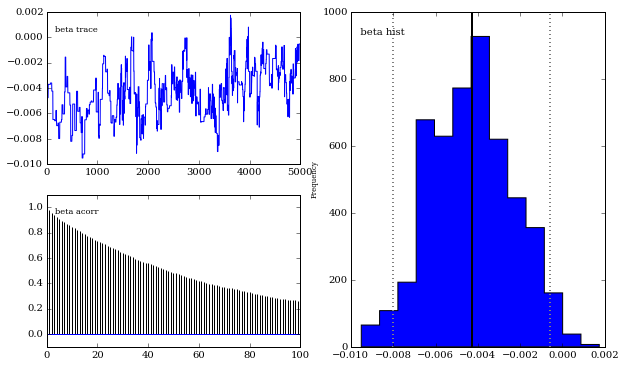

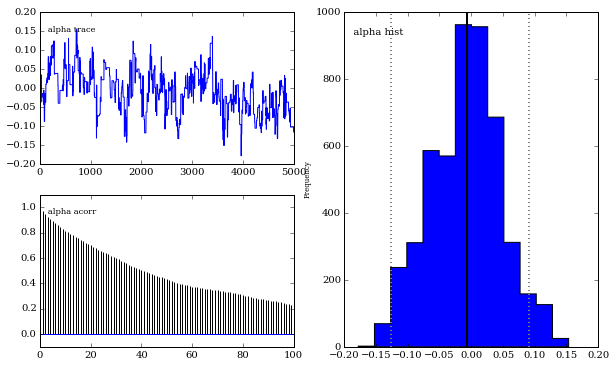

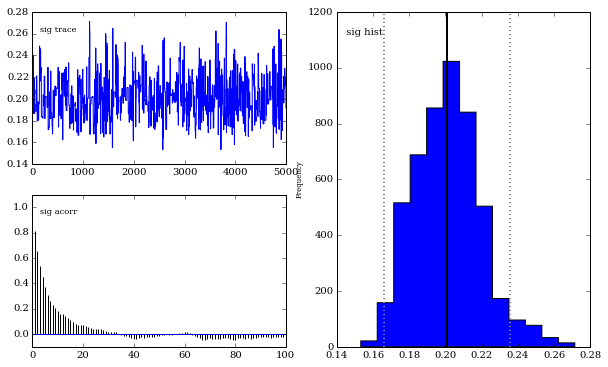

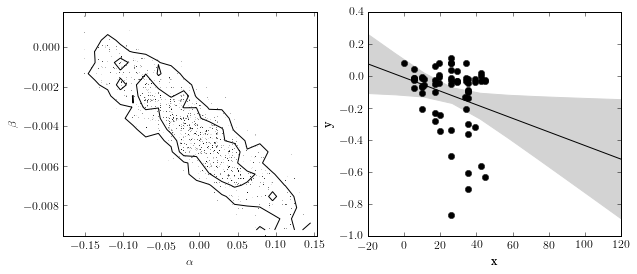

In [134]:
R = MCMC(pymc_simple_linear)
R.sample(10000, burn=5000)
vs = ['alpha', 'beta', 'sig']

trace = []
for v in vs:
    trace.extend([R.trace(v)[:]])
    
trace = np.asarray(trace)

corner(trace.T, labels = vs)
plt.show()

plt.rc('text', usetex = False)
Matplot.plot(R)
plt.show()
plt.rc('text', usetex = True)

plot_MCMC_results(xdata = r, ydata = ydata, trace = trace)
plt.show()

#now fit a plane to pPXF's velocity results

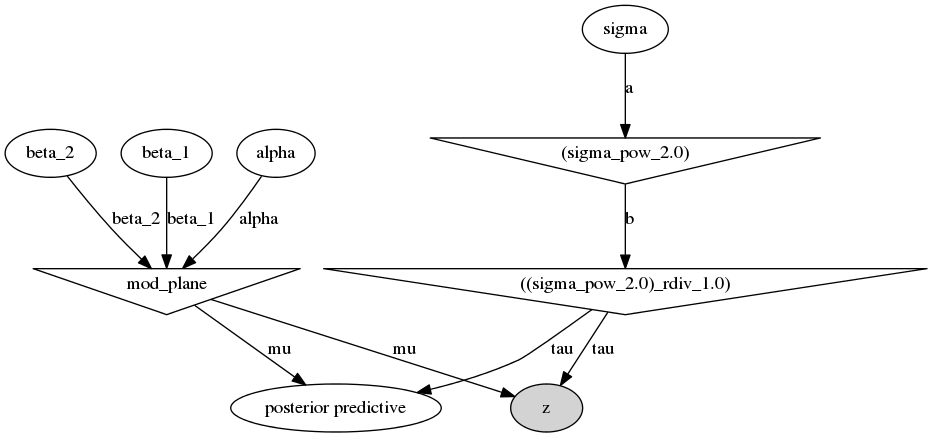

In [135]:
xpos = fiberfits['ra']
ypos = fiberfits['dec']
zdata = fiberfits['V']
zdata_err = fiberfits['dV']

'''
model:

plane fit (same deal with slopes/angles as before)
'''

alpha_guess = zdata[r == 0][0]

#priors
alpha = Uniform('alpha', lower = alpha_guess - 200., upper = alpha_guess + 200., value = alpha_guess)
beta_1 = Uniform('beta_1', lower = -np.pi/2., upper = np.pi/2.)
beta_2 = Uniform('beta_2', lower = -np.pi/2., upper = np.pi/2.)
sigma = Uniform('sigma', lower = 0., upper = 1000.)

#actual model
@deterministic
def mod_plane(xpos = xpos, ypos = ypos, alpha = alpha, beta_1 = beta_1, beta_2 = beta_2):
    return alpha + np.tan(beta_1) * xpos + np.tan(beta_2) * ypos

#likelihood
z = Normal('z', mu = mod_plane, tau = 1./sigma**2., value = zdata, observed = True)

#create a posterior predictive
post_pred = Normal('posterior predictive', mu = mod_plane, tau = 1./sigma**2.)

pymc_simple_plane = dict(alpha = alpha, beta_1 = beta_1, beta_2 = beta_2, sigma = sigma, z = z, post_pred = post_pred)

simple_plane_graph = graph.graph(Model([alpha, beta_1, beta_2, sigma, z, post_pred]))
simple_plane_graph.write_png('simple_plane_graph.png')

Image(filename = 'simple_plane_graph.png')


Chain 0
 [-----------------100%-----------------] 20000 of 20000 complete in 20.8 sec
Chain 1
 [-----------------100%-----------------] 20000 of 20000 complete in 20.6 sec
Chain 2
 [-----------------100%-----------------] 20000 of 20000 complete in 20.5 sec
Chain 3
 [-----------------100%-----------------] 20000 of 20000 complete in 19.9 sec
Chain 4
 [-----------------100%-----------------] 20000 of 20000 complete in 20.9 sec

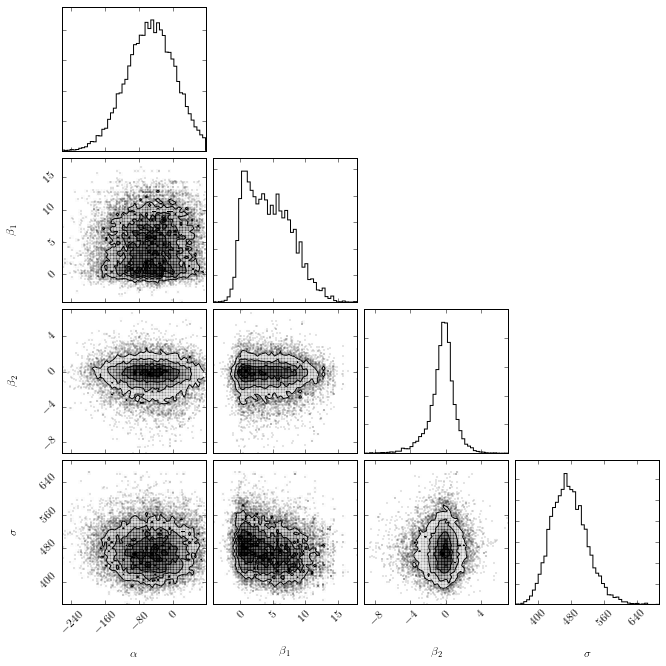

Plotting sigma
Plotting beta_2
Plotting alpha
Plotting beta_1


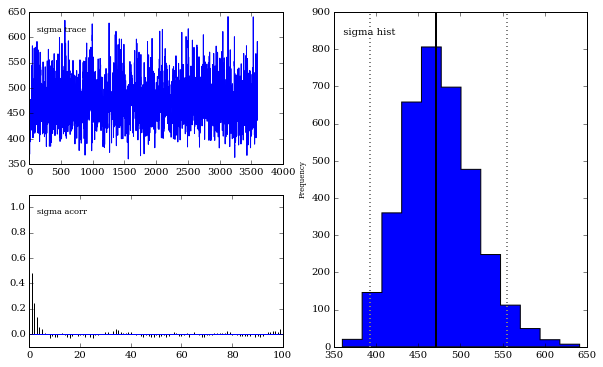

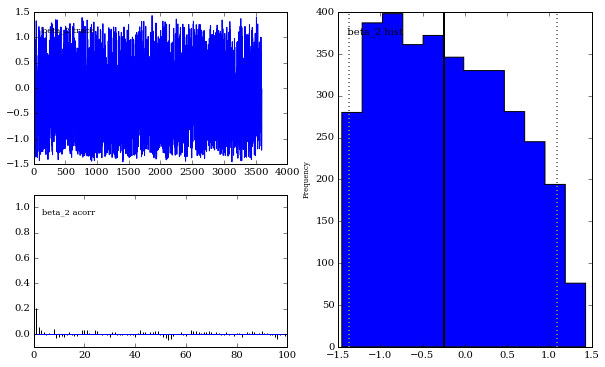

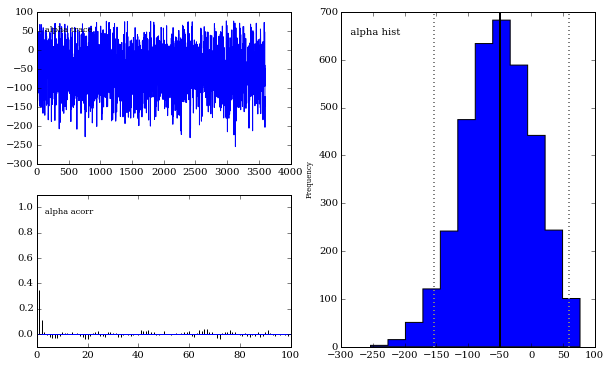

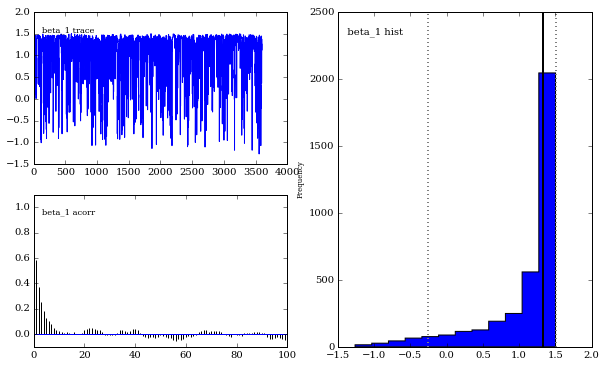

In [136]:
R = MCMC(pymc_simple_plane)
for i in range(5):
    print '\nChain {}'.format(i)
    R.sample(20000, burn=2000, thin = 5)
vs = [r'$\alpha$', r'$\beta_1$', r'$\beta_2$', r'$\sigma$']

trace = []
for v in vs:
    if 'beta' in v: #transform from angle to slope
        trace.extend([np.tan(R.trace(v.replace('\\', '').replace('$', ''), chain = None)[:])])
    else:
        trace.extend([R.trace(v.replace('\\', '').replace('$', ''), chain = None)[:]])
    
trace = np.asarray(trace)

corner(trace.T, labels = vs)
plt.show()

plt.rc('text', usetex = False)
Matplot.plot(R)
plt.show()
plt.rc('text', usetex = True)

#plane with measured z errors

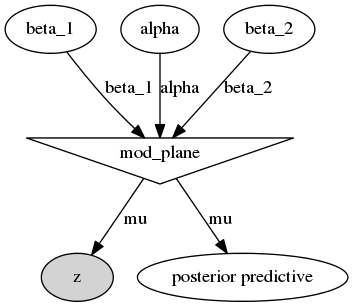

In [235]:
xpos = fiberfits['ra']
ypos = fiberfits['dec']
zdata = fiberfits['V']
zdata_err = fiberfits['dV']

'''
model:

plane fit (same deal with slopes/angles as before)
instead of modeling sigma, we just use zdata_err
'''

alpha_guess = zdata[r == 0][0]

#priors
alpha = Normal('alpha', mu = alpha_guess, tau = 1./500**2., value = alpha_guess)
beta_1 = VonMises('beta_1', mu = 0., kappa = 0.5, value = 0.) #Von Mises are on the unit circle from -pi to pi
beta_2 = VonMises('beta_2', mu = 0., kappa = 0.5, value = 0.) #so we'll transform them to -pi/2 to pi/2
#when you divide by one of these priors in_place, though, you get naming weirdness
#so transform them in formulas and chains

#actual model
@deterministic
def mod_plane(xpos = xpos, ypos = ypos, alpha = alpha, beta_1 = beta_1, beta_2 = beta_2):
    return alpha + np.tan(beta_1/2.) * xpos + np.tan(beta_2/2.) * ypos

#likelihood
z = Normal('z', mu = mod_plane, tau = 1./zdata_err**2., value = zdata, observed = True)

#posterior predictive
post_pred = Normal('posterior predictive', mu = mod_plane, tau = 1./zdata_err**2.)

pymc_simple_plane_zerr = Model({'alpha': alpha, 'beta_1': beta_1, 'beta_2': beta_2, 
                                    'z': z, 'post_pred': post_pred})

simple_plane_zerr_graph = graph.graph(pymc_simple_plane_zerr)
simple_plane_zerr_graph.write_png('simple_plane_graph_zerr.png')

Image(filename = 'simple_plane_graph_zerr.png')


Chain 0
 [-----------------100%-----------------] 40000 of 40000 complete in 72.9 sec
Chain 1
 [-----------------100%-----------------] 40000 of 40000 complete in 79.9 sec
Chain 2
 [-----------------100%-----------------] 40000 of 40000 complete in 76.0 sec
Chain 3
 [-----------------100%-----------------] 40000 of 40000 complete in 69.8 sec
Chain 4
 [-----------------100%-----------------] 40000 of 40000 complete in 68.8 sec
Chain 5
 [-----------------100%-----------------] 40000 of 40000 complete in 78.8 sec
Chain 6
 [-----------------100%-----------------] 40000 of 40000 complete in 71.7 sec
Chain 7
 [-----------------100%-----------------] 40000 of 40000 complete in 71.8 sec
Chain 8
 [-----------------100%-----------------] 40000 of 40000 complete in 72.3 sec
Chain 9
 [-----------------100%-----------------] 40000 of 40000 complete in 72.7 sec

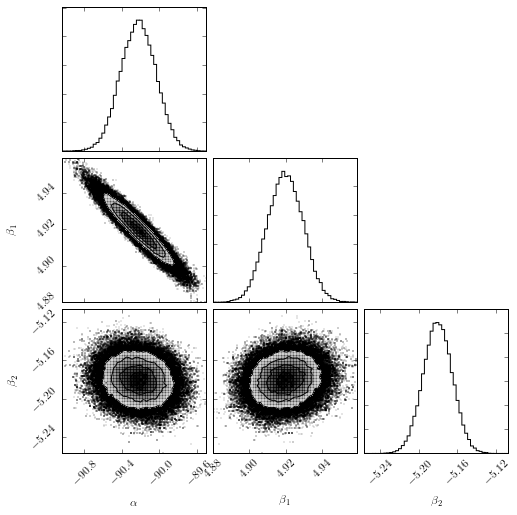

Plotting alpha
Plotting beta_2
Plotting beta_1


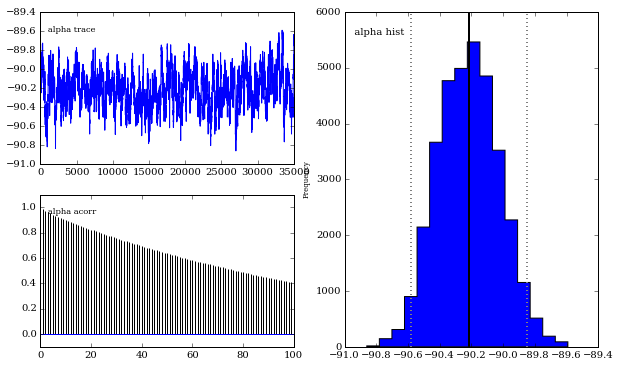

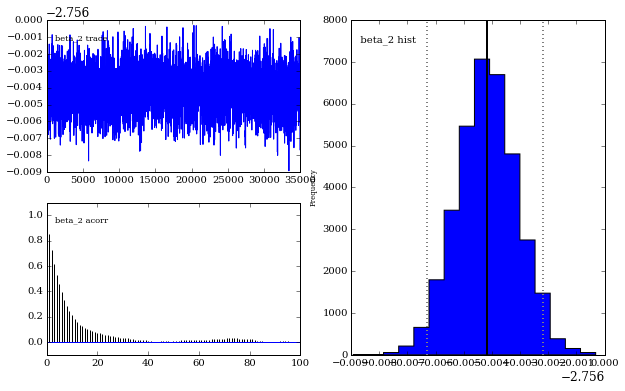

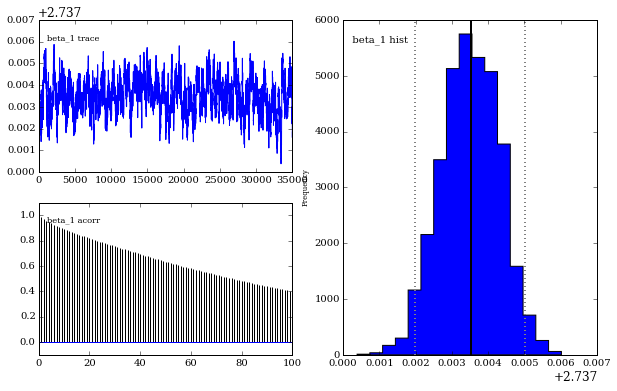

In [239]:
R = MCMC(pymc_simple_plane_zerr)

for i in range(10):
    print '\nChain {}'.format(i)
    R.sample(40000, burn=5000)
vs = [r'$\alpha$', r'$\beta_1$', r'$\beta_2$']

trace = []
for v in vs:
    if 'beta' in v: #transform from angle to slope
        trace.extend([np.tan(R.trace(v.replace('\\', '').replace('$', ''), chain = None)[:]/2.)])
    else:
        trace.extend([R.trace(v.replace('\\', '').replace('$', ''), chain = None)[:]])
    
trace = np.asarray(trace)

corner(trace.T, labels = vs)
plt.show()

plt.rc('text', usetex = False)
Matplot.plot(R)
plt.show()
plt.rc('text', usetex = True)

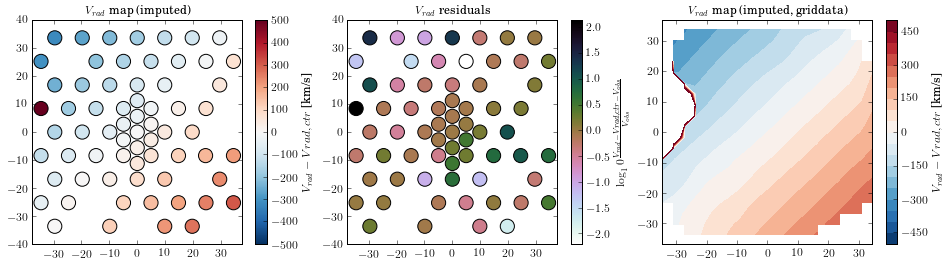

In [250]:
plt.figure(figsize = (16, 4))
ax1 = plt.subplot(131)
sc = ax1.scatter(xpos, ypos, c = R.post_pred.value - R.post_pred.value[0], s = 200, cmap = 'RdBu_r', 
            vmin = -500., vmax = 500.)
ax1.set_aspect('equal', 'datalim')
plt.colorbar(sc, label = '$V_{rad} - V{rad,ctr}$ [km/s]')
ax1.set_title('$V_{rad}$ map (imputed)')

ax3 = plt.subplot(132)
sc2 = ax3.scatter(xpos, ypos, c = np.log10(np.abs((R.post_pred.value - R.post_pred.value[0] - zdata)/zdata)), s = 200, 
                  cmap = 'cubehelix_r')
ax3.set_aspect('equal', 'datalim')
plt.colorbar(sc2, label = r'$\log_10 \frac{V_{rad} - V{rad,ctr} - V_{obs}}{V_{obs}}$')
ax3.set_title('$V_{rad}$ residuals')

xcoord = np.linspace(np.min(xpos), np.max(xpos), 20)
ycoord = np.linspace(np.min(ypos), np.max(ypos), 20)
Xi, Yi = np.meshgrid(xcoord, ycoord)

Zii = griddata(xpos, ypos, R.post_pred.value - R.post_pred.value[0], xcoord, ycoord, interp = 'linear')

ax2 = plt.subplot(133)
con = ax2.contourf(Xi, Yi, Zii, cmap = 'RdBu_r', levels = np.linspace(-500., 500., 21))
ax2.set_aspect('equal', 'datalim')
plt.colorbar(con, label = '$V_{rad} - V{rad,ctr}$ [km/s]')
ax2.set_title('$V_{rad}$ map (imputed, griddata)')
plt.show()

#plane with measured errors and outliers

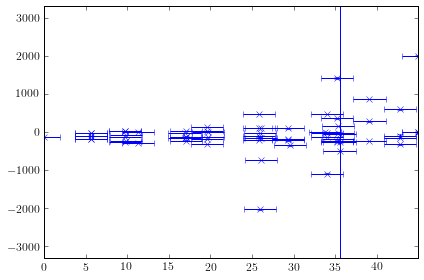

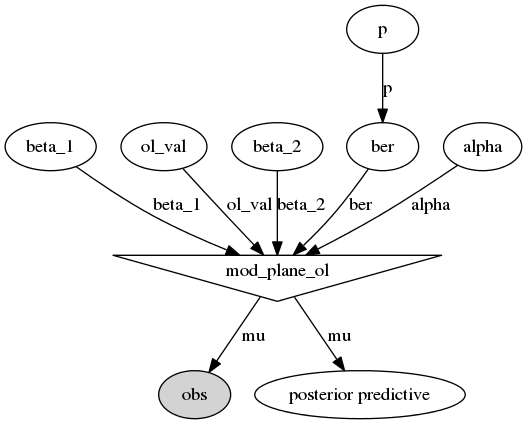

In [253]:
xpos = fiberfits['ra']
ypos = fiberfits['dec']
zdata = fiberfits['V']
zdata_err = fiberfits['dV']

fig = plt.figure()
ax = plt.subplot(111)

ax.plot(r, zdata, visible = False)
ylims = ax.get_ylim()
yr = ylims[1] - ylims[0]
ylims = (ylims[0] - 0.05*yr, ylims[1] + 0.05*yr)

ax.errorbar(r, zdata, xerr = dr_fiber, yerr = zdata_err, fmt = 'x', c = 'b')
ax.set_xlim([0., np.max(r)])
ax.set_ylim(ylims)
plt.tight_layout()
plt.show()

'''
model:

plane fit (same deal with slopes/angles as before)
instead of modeling sigma, we just use zdata_err
and we have a bernoulli process that models outliers
'''

alpha_guess = zdata[r == 0][0]

#priors
alpha = Normal('alpha', mu = alpha_guess, tau = 1./500**2., value = alpha_guess)
beta_1 = VonMises('beta_1', mu = 0., kappa = 0.5, value = 0.) #Von Mises are on the unit circle from -pi to pi
beta_2 = VonMises('beta_2', mu = 0., kappa = 0.5, value = 0.) #so we'll transform them to -pi/2 to pi/2
#when you divide by one of these priors in_place, though, you get naming weirdness
#so transform them in formulas and chains
p = Uniform('p', lower = 0, upper = 1, value = 0.8) #prior on probability of inlier
ber = Bernoulli('ber', p = p, size = len(zdata)) #probability of inlier
ol_val = Cauchy('ol_val', alpha = 0., beta = 1000.) #when an outlier happens, what will it look like?

#actual model of plane
@deterministic
def mod_plane_ol(xpos = xpos, ypos = ypos, alpha = alpha, beta_1 = beta_1, beta_2 = beta_2, ber = ber, ol_val = ol_val):
    return ber * (alpha + np.tan(beta_1/2.) * xpos + np.tan(beta_2/2.) * ypos) + (1 - ber) * ol_val


#likelihood
obs = Normal('obs', mu = mod_plane_ol, tau = 1./zdata_err**2., value = zdata, observed = True)

#posterior predictive
post_pred = Normal('posterior predictive', mu = mod_plane_ol, tau = 1./zdata_err**2.)

pymc_simple_plane_zerr_ol = Model({'alpha': alpha, 'beta_1': beta_1, 'beta_2': beta_2, 'p': p, 'ber': ber, 
                                   'ol_val': ol_val, 'obs': obs, 'post_pred': post_pred})

simple_plane_zerr_ol_graph = graph.graph(pymc_simple_plane_zerr_ol)
simple_plane_zerr_ol_graph.write_png('simple_plane_graph_zerr_ol.png')

Image(filename = 'simple_plane_graph_zerr_ol.png')


Chain 0
 [-----------------100%-----------------] 100000 of 100000 complete in 377.7 sec
Chain 1
 [-----------------100%-----------------] 100000 of 100000 complete in 369.7 sec
Chain 2
 [-----------------100%-----------------] 100000 of 100000 complete in 347.4 sec
Chain 3
 [-----------------100%-----------------] 100000 of 100000 complete in 349.1 sec
Chain 4
 [-----------------100%-----------------] 100000 of 100000 complete in 346.0 sec
Chain 5
 [-----------------100%-----------------] 100000 of 100000 complete in 346.4 sec
Chain 6
 [-----------------100%-----------------] 100000 of 100000 complete in 344.8 sec
Chain 7
 [-----------------100%-----------------] 100000 of 100000 complete in 345.5 sec
Chain 8
 [-----------------100%-----------------] 100000 of 100000 complete in 346.4 sec
Chain 9
 [-----------------100%-----------------] 100000 of 100000 complete in 345.7 sec

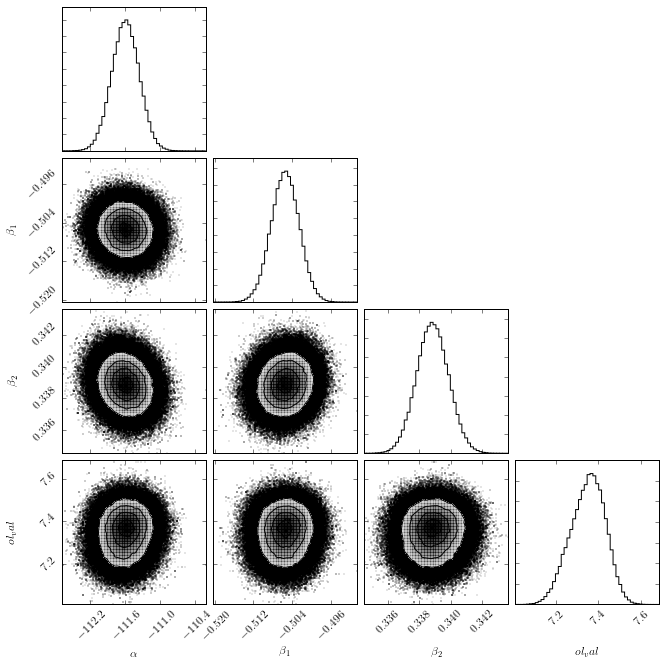

Plotting ol_val
Plotting beta_1
Plotting p
Plotting alpha
Plotting beta_2


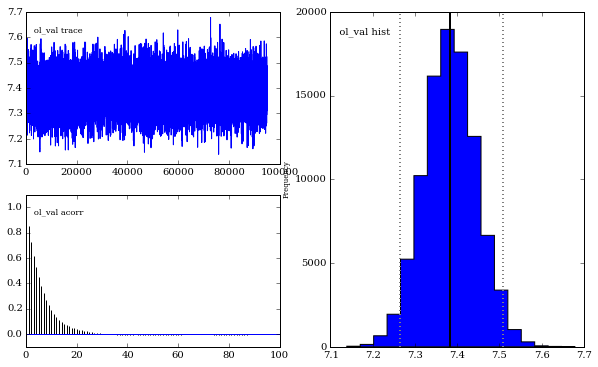

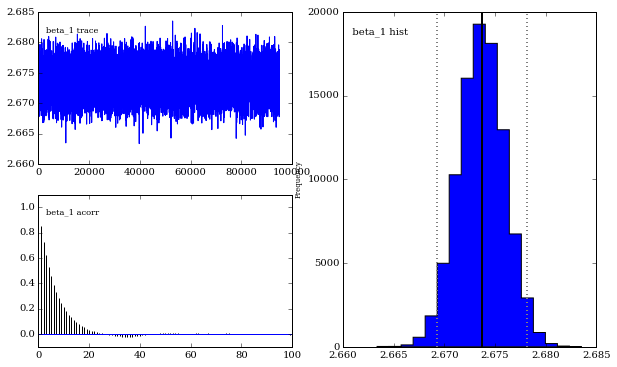

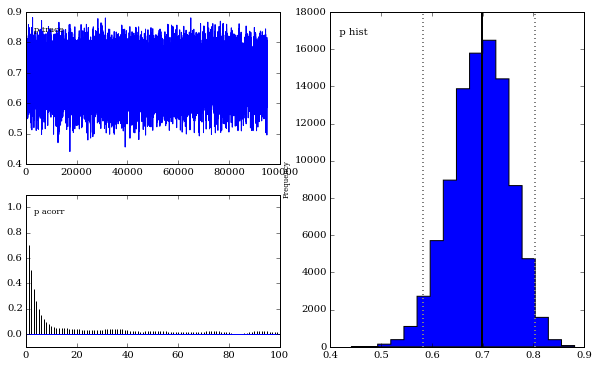

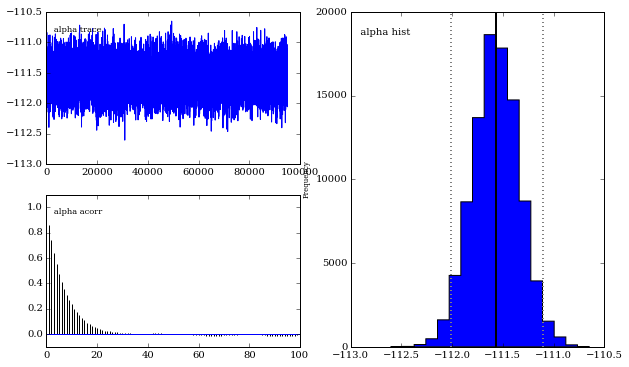

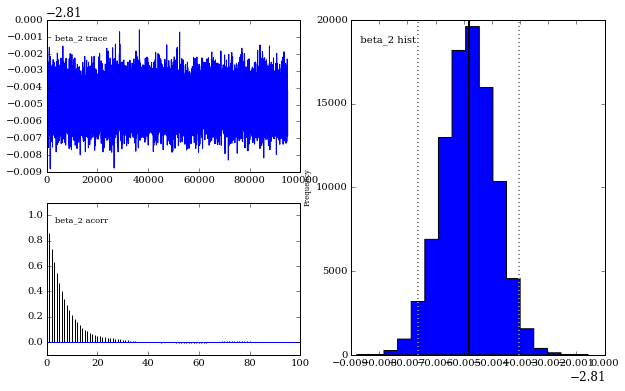

In [266]:
R = MCMC(pymc_simple_plane_zerr_ol)

for i in range(10):
    print '\nChain {}'.format(i)
    R.sample(iter = 100000, burn = 5000)
vs = [r'$\alpha$', r'$\beta_1$', r'$\beta_2$', r'$ol_val$']

trace = []
for v in vs:
    if 'beta' in v: #transform from angle to slope
        trace.extend([np.tan(R.trace(v.replace('\\', '').replace('$', ''), chain = None)[:])])
    else:
        trace.extend([R.trace(v.replace('\\', '').replace('$', ''), chain = None)[:]])
    
trace = np.asarray(trace)

corner(trace.T, labels = vs)
plt.show()

plt.rc('text', usetex = False)
Matplot.plot(R)
plt.show()
plt.rc('text', usetex = True)

In [267]:
print 'inliers: {}'.format(np.sum(R.trace('ber')[:] == True))
print 'outliers: {}'.format(np.sum(R.trace('ber')[:] == False))

print 'inlier fraction: {}'.format( 
    float(np.sum(R.trace('ber')[:] == True))/(np.sum(R.trace('ber')[:] == False) + np.sum(R.trace('ber')[:] == True)) )

inliers: 4403702
outliers: 1866298
inlier fraction: 0.702344816587


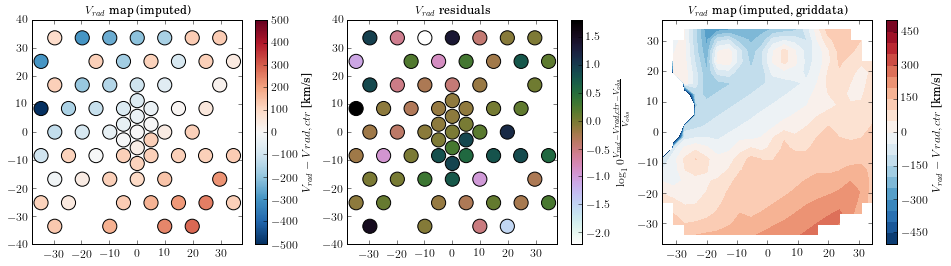

In [268]:
plt.figure(figsize = (16, 4))
ax1 = plt.subplot(131)
sc = ax1.scatter(xpos, ypos, c = R.post_pred.value - R.post_pred.value[0], s = 200, cmap = 'RdBu_r', 
            vmin = -500., vmax = 500.)
ax1.set_aspect('equal', 'datalim')
plt.colorbar(sc, label = '$V_{rad} - V{rad,ctr}$ [km/s]')
ax1.set_title('$V_{rad}$ map (imputed)')

ax3 = plt.subplot(132)
sc2 = ax3.scatter(xpos, ypos, c = np.log10(np.abs((R.post_pred.value - R.post_pred.value[0] - zdata)/zdata)), s = 200, 
                  cmap = 'cubehelix_r')
ax3.set_aspect('equal', 'datalim')
plt.colorbar(sc2, label = r'$\log_10 \frac{V_{rad} - V{rad,ctr} - V_{obs}}{V_{obs}}$')
ax3.set_title('$V_{rad}$ residuals')

xcoord = np.linspace(np.min(xpos), np.max(xpos), 20)
ycoord = np.linspace(np.min(ypos), np.max(ypos), 20)
Xi, Yi = np.meshgrid(xcoord, ycoord)

Zii = griddata(xpos, ypos, R.post_pred.value - R.post_pred.value[0], xcoord, ycoord, interp = 'linear')

ax2 = plt.subplot(133)
con = ax2.contourf(Xi, Yi, Zii, cmap = 'RdBu_r', levels = np.linspace(-500., 500., 21))
ax2.set_aspect('equal', 'datalim')
plt.colorbar(con, label = '$V_{rad} - V{rad,ctr}$ [km/s]')
ax2.set_title('$V_{rad}$ map (imputed, griddata)')
plt.show()


Chain 0
 [-----------------100%-----------------] 100000 of 100000 complete in 352.8 sec

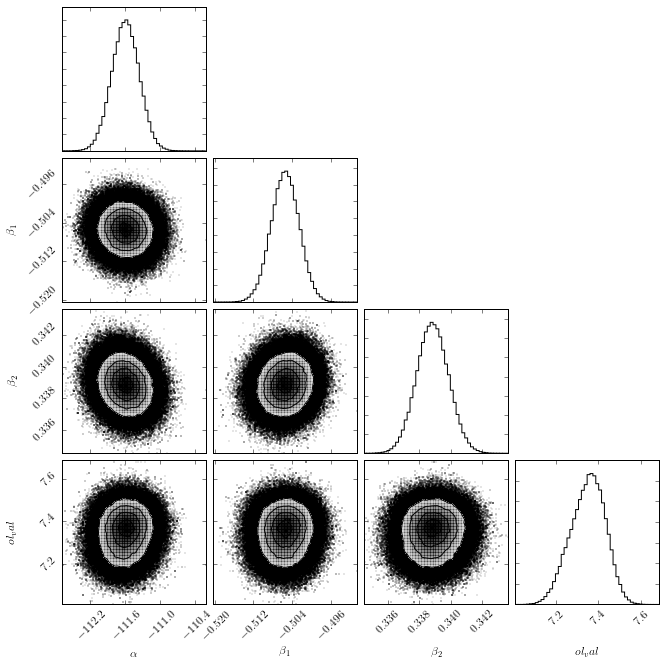

Plotting ol_val
Plotting beta_1
Plotting p
Plotting alpha
Plotting beta_2


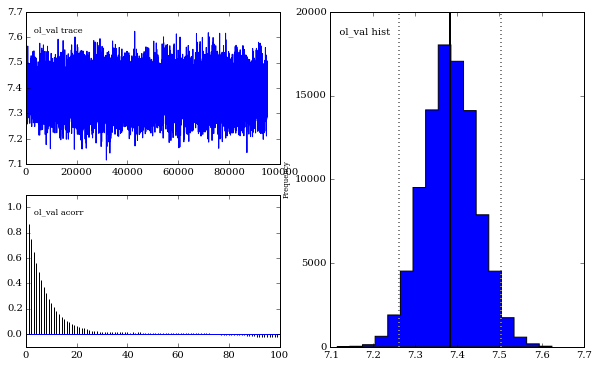

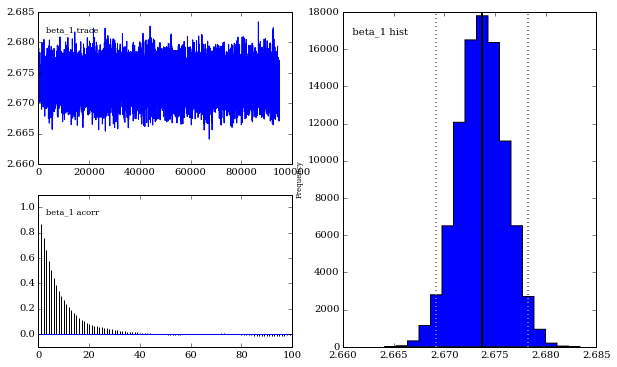

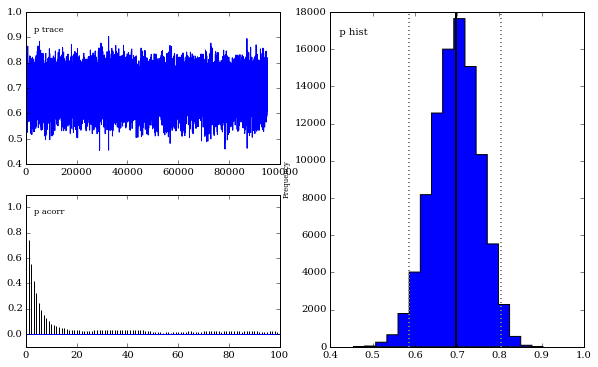

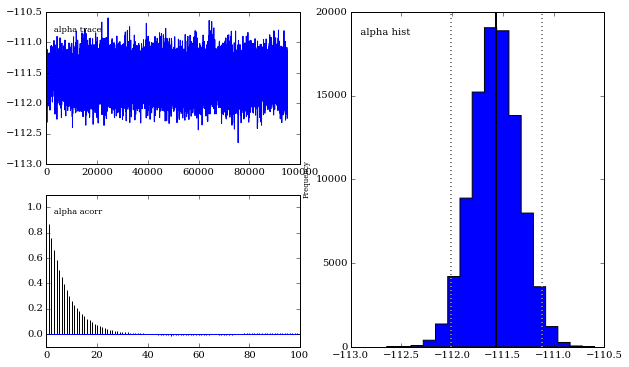

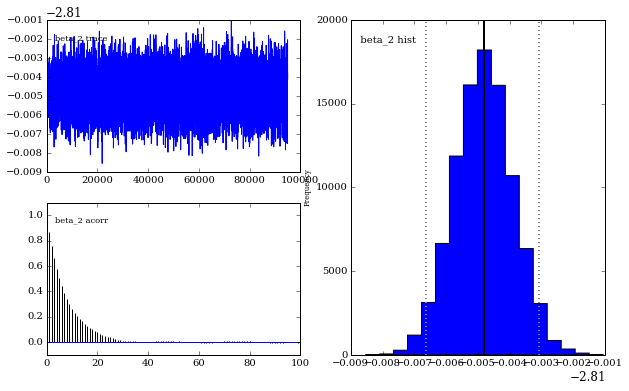

In [270]:
R2 = MCMC(pymc_simple_plane_zerr_ol)

for i in range(1):
    print '\nChain {}'.format(i)
    R2.sample(iter = 100000, burn = 5000)
vs = [r'$\alpha$', r'$\beta_1$', r'$\beta_2$', r'$ol_val$']

trace = []
for v in vs:
    if 'beta' in v: #transform from angle to slope
        trace.extend([np.tan(R.trace(v.replace('\\', '').replace('$', ''), chain = None)[:])])
    else:
        trace.extend([R.trace(v.replace('\\', '').replace('$', ''), chain = None)[:]])
    
trace = np.asarray(trace)

corner(trace.T, labels = vs)
plt.show()

plt.rc('text', usetex = False)
Matplot.plot(R2)
plt.show()
plt.rc('text', usetex = True)

#modeling increased spread

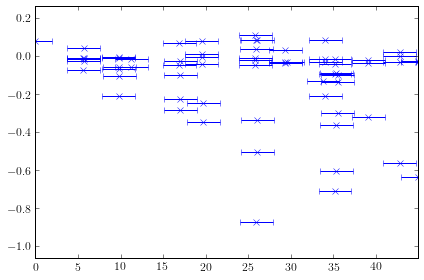

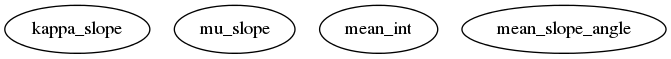

In [293]:
xpos = fiberfits['ra']
ypos = fiberfits['dec']
r = np.sqrt(xpos**2. + ypos**2.)

qty = 'Z'

if 'd' + qty in fiberfits.columns:
    yerr = fiberfits['d' + qty]
else: yerr = None

qty = np.asarray(fiberfits[qty])

fig = plt.figure()
ax = plt.subplot(111)

ax.plot(r, ydata, visible = False)
ylims = ax.get_ylim()
yr = ylims[1] - ylims[0]
ylims = (ylims[0] - 0.05*yr, ylims[1] + 0.05*yr)

ax.errorbar(r, ydata, xerr = dr_fiber, yerr = yerr, fmt = 'x', c = 'b')
ax.set_xlim([0., np.max(r)])
ax.set_ylim(ylims)
plt.tight_layout()
plt.show()

'''
model:

linear fit of a quantity with some linearly-increasing spread
'''

#priors
mu_slope = Uniform('mu_slope', lower = -np.pi/2., upper = np.pi/2.)
kappa_slope = Uniform('kappa_slope', lower = 0., upper = 10.)

mean_int = Uniform('mean_int', lower = -2., upper = 1.)
mean_slope_angle = VonMises('mean_slope_angle', mu = 0., kappa = 0.5, value = 0.)

#actual model
@deterministic
def linear_varying_sigma_model_():
    

#likelihood


#posterior predictive


pymc_linear_varying_sigma = Model(
    {
        'mu_slope': mu_slope, 'kappa_slope': kappa_slope, 
        'mean_int': mean_int, 'mean_slope_angle': mean_slope_angle
    })
    
graph_filename = 'pymc_linear_varying_sigma.png'

pymc_linear_varying_sigma_graph = graph.graph(pymc_linear_varying_sigma)
pymc_linear_varying_sigma_graph.write_png(graph_filename)

Image(filename = graph_filename)

In [295]:
alpha = Uniform('alpha', -100, 100)
spread = Uniform('spread', 0.5, 5)

@pymc.stochastic(observed=False)
def beta(value=0):
    return -1.5 * np.log(1 + value ** 2)

@pymc.stochastic(observed=False)
def sigma(value=1):
    return -np.log(np.abs(value))

# Define the form of the model and likelihood
@pymc.deterministic
def y_model(x=r, alpha=alpha, beta=beta):
    return alpha + beta * x

y = pymc.Cauchy('y', y_model, spread, observed=True, value=qty)

# package the full model in a dictionary
model1 = dict(alpha=alpha, beta=beta, sigma=sigma,
              y_model=y_model, y=y)

S = pymc.MCMC(model1)
S.sample(iter=100000, burn=50000)

 [-----------------100%-----------------] 100000 of 100000 complete in 56.2 sec

In [298]:
S.stats()

{'alpha': {'95% HPD interval': array([-1.06344507,  1.12844778]),
  'mc error': 0.018989662777798975,
  'mean': -0.025265753484328444,
  'n': 50000,
  'quantiles': {2.5: -1.1169281233008141,
   25: -0.40080627240247962,
   50: -0.037267170981452033,
   75: 0.36026773942602286,
   97.5: 1.0901350201791435},
  'standard deviation': 0.56038047166143834},
 'beta': {'95% HPD interval': array([-0.04290837,  0.03612502]),
  'mc error': 0.0006701265386240367,
  'mean': -0.0036210075567101561,
  'n': 50000,
  'quantiles': {2.5: -0.043933382684471257,
   25: -0.017334860888116609,
   50: -0.0032550768997793387,
   75: 0.010065474068926966,
   97.5: 0.035573157942770738},
  'standard deviation': 0.020256545641500364},
 'sigma': {'95% HPD interval': array([-24.05224914,  41.28471288]),
  'mc error': 1.5338507269582402,
  'mean': -0.05965701982171151,
  'n': 50000,
  'quantiles': {2.5: -30.45284047669206,
   25: -0.096330577032548256,
   50: 0.00012590786289535215,
   75: 0.083020545371284352,
   9